In [ ]:
import itertools

import libmambapy

import mamba_error_reporting as mer

# Problem definition

## PubGrub Example

The example given by Natalie Weizenbaum (image credits https://nex3.medium.com/pubgrub-2fb6470504f)

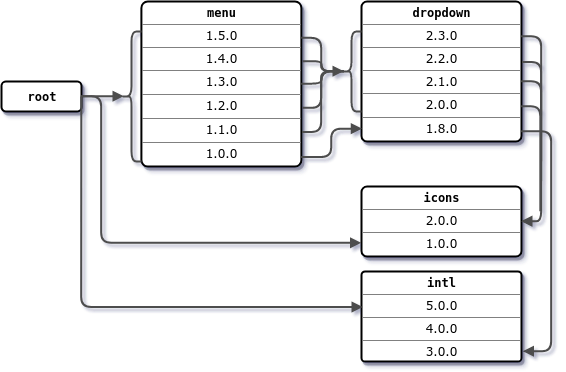

### Ideal output (from PubGrub)
```
Because dropdown >=2.0.0 depends on icons >=2.0.0 and root depends
  on icons <2.0.0, dropdown >=2.0.0 is forbidden.

And because menu >=1.1.0 depends on dropdown >=2.0.0, menu >=1.1.0
  is forbidden.

And because menu <1.1.0 depends on dropdown >=1.0.0 <2.0.0 which
  depends on intl <4.0.0, every version of menu requires intl
  <4.0.0.

So, because root depends on both menu >=1.0.0 and intl >=5.0.0,
  version solving failed.
```

# Conflict analysis

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
solver, pool = mer.problems.create_pubgrub()
success = solver.solve()
if not success:
    print(mer.messaging.old_error_report(solver))

In [ ]:
pbs = mer.analysis.all_problems_structured_df(solver)
deps = mer.analysis.select_solvables_df(
    pool, pbs[~pbs.dependency.isnull()].dependency_id.drop_duplicates()
)
solvables = mer.analysis.id_to_pkg_info_df(pool,
    itertools.chain(
    pbs[pbs.source_is_pkg].source_id,
    pbs[pbs.target_is_pkg].target_id,
    deps.solvable_id
)).drop_duplicates().set_index('id').sort_index()

In [ ]:
pbs

In [ ]:
deps

In [ ]:
solvables

In [ ]:
def build_problem_graph_solvable(pbs, solvables, deps):
    g = nx.DiGraph()
    
    # All solvables
    for solv_id, solv_info in solvables.iterrows():
        g.add_node(solv_id, **solv_info, repr="{name}-{version}-{build_string}".format(**solv_info))
       
    # TODO include other JOBs
    # TODO figure what to do with dependency with null source
    pbs_with_deps = pbs[pbs.type.isin([libmambapy.SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES])]
    pbs_with_deps = pbs_with_deps.join(deps.set_index("dependency_id"), on="dependency_id")
    
    # All dependency edges
    for _, pb in pbs_with_deps.iterrows():
        g.add_edge(
            pb.source_id, pb.solvable_id,
            dependency_id=pb.dependency_id, dependency=pb.dependency
        )

    return g

In [ ]:
def plot_dag(graph):
    plt.figure(figsize=(10, 6), dpi=300)

    # Position using levels
    pos = {}
    for level, nodes in enumerate(nx.topological_generations(graph)):
        pos.update({n: (x, -level) for x, n in enumerate(nodes)})

    options = {"node_size": 800, "alpha": 0.5}
    nx.draw_networkx_nodes(graph, pos, node_color="blue", **options)
    nx.draw_networkx_edges(graph, pos, **options)

    # some labels
    labels = {n: attr["repr"] for n, attr in graph.nodes.items()}
    # nx.draw_networkx_labels(g, pos, labels, font_size=22, font_color="whitesmoke")
    nx.draw_networkx_labels(graph, pos, labels, font_size=7)

    plt.tight_layout()
    plt.axis("off")
    plt.show()

In [ ]:
g = build_problem_graph_solvable(pbs, solvables, deps)
plot_dag(g)

In [ ]:
def all_equal(*args):
    return all(a == b for a, b in itertools.pairwise(args))


def compressable_dependencies(graph, deps_to_solvables):
    to_compress = {}
    for dep_id, solvables in deps_to_solvables.items():
        more_than_1 = len(solvables) > 1
        same_predecessors = all_equal(list(graph.predecessors(n)) for n in solvables)
        same_sucessors = all_equal(list(graph.successors(n)) for n in solvables)
        if more_than_1 and same_predecessors and same_sucessors:
            to_compress[dep_id] = solvables
    return to_compress


def dependency_to_solvables(graph: nx.DiGraph):
    solvs = {}
    names = {}
    for n, s in graph.edges:
        dep_id = graph.edges[(n, s)]["dependency_id"]
        solvs.setdefault(dep_id, set()).add(s)
        names[dep_id] = graph.edges[(n, s)]["dependency"]  # Always the same
    return solvs, names


# TODO their may be multiple dependencies resolving to the same solvables.
# We want to preserve that, in particluar in the 'dependency' attribute of the edges.
def compress_dependencies(graph: nx.DiGraph, deps):
    graph = graph.copy()
    dep_solvs, dep_names = dependency_to_solvables(graph)
    to_compress = compressable_dependencies(graph, dep_solvs)
    for dep_id, solvables in to_compress.items():
        predecessors = graph.predecessors(next(iter(solvables)))
        successors = graph.successors(next(iter(solvables)))
        graph.remove_nodes_from(solvables)
        graph.add_node(dep_id, repr=dep_names[dep_id], dependency=dep_names[dep_id])
        # TODO rebuild dependency information
        graph.add_edges_from((p, dep_id) for p in predecessors)
        graph.add_edges_from((dep_id, s) for s in successors)
    return graph   

In [ ]:
gc = compress_dependencies(g, deps)
plot_dag(gc)

In [ ]:
def get_root_ancestor(graph, node):
    root_parents = set()
    visited = {node}
    while len(visited) > 0:
        n = visited.pop()
        parents = set(graph.predecessors(n))
        if len(parents) > 0:
            visited = visited.union(parents)
        else:
            root_parents.add(n)
    return root_parents

            
def explain_errors(graph):
    # leaves = [n for n in graph.nodes() if graph.in_degree(n) >= 1]
    leaves = [n for n in graph.nodes() if graph.out_degree(n) == 0 and graph.in_degree(n) >= 1]

    # print([str(graph.nodes[l]["pkg_info"]) for l in leaves])
    conflicts = {}
    for leaf in leaves:
        leaf_pkg_repr = "{name}-{version}-{build_string}".format(**graph.nodes[leaf])
        leaf_in_dependencies = set(
            graph.edges[e]["dependency"] for e in graph.in_edges(leaf)
        )
        
        ancestors = get_root_ancestor(graph, leaf)
        ancestor_pkg_repr = ["{name}-{version}-{build_string}".format(**graph.nodes[n]) for n in ancestors]
        ancestor_out_dependencies = set(
            graph.edges[e]["dependency"] for a in ancestors for e in graph.out_edges(a) 
        )
        print(f"Leaf: {leaf_pkg_repr}")
        print("  has dependencies " + " & ".join(leaf_in_dependencies))
        print(f"Ancestor: " + ", ".join(ancestor_pkg_repr))
        print("  has dependencies " + " & ".join(ancestor_out_dependencies))
        print()

In [ ]:
explain_errors(g)